# Objective
In this notebook, we will train our MicroSplit network on HT-LIF24 dataset. 
The dataset has four channels: Nucleus, Microtubules, Nuclear Membrane and Centromere/Kinetocore.
This dataset has acquisitions with different exposure durations.
Lower exposure durations have lower SNR and higher exposure durations have higher SNR.

This notebook caters to a two-channel unmixing task.
Therefore, at the beginning, the user has the option to select the two channels and the exposure duration they want to train the network on.


## Training Methodology
Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. 
Besides the primary input patch, we also feed LC inputs to MicroSplit. We introduced LC inputs in [μSplit: efficient image decomposition for microscopy data](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), which enabled the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from our previous work [denoiSplit: a method for joint microscopy image splitting and unsupervised denoising](https://eccv.ecva.net/virtual/2024/poster/2538). 

The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss. For both denoiSplit and μSplit, their loss expression have two terms: KL divergence loss and likelihood loss. For more details, please refer to the respective papers.

<div class="alert alert-block alert-info">
<b>Important:</b> This notebook is optional. Only run this notebook if you want to train the MicroSplit model from scratch. Pretrained model checkpoints is available and so one could directly go to the corresponding evaluation notebook. By default this notebook runs example training for 5 epochs!
</div>

#### General imports

In [2]:
import pooch
from pathlib import Path
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from careamics.lightning import VAEModule

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import (
    plot_training_metrics,
    plot_input_patches,
    plot_training_outputs,
)

## Selection of a sub-dataset 

In [3]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

class Channels:
    Nucleus = 0
    MicroTubules = 1
    NuclearMembrane = 2
    Centromere = 3

class ExposureDuration:
    VeryLow = "2ms"
    Low = "3ms"
    Medium = "5ms"
    High = "20ms"
    VeryHigh = "500ms"

allowed_exposure_durations = [ExposureDuration.VeryLow, ExposureDuration.Low, ExposureDuration.Medium, ExposureDuration.High, ExposureDuration.VeryHigh]

## Select the channels and exposure duration
<div class="alert alert-block alert-info">
<b> Task: </b>Set two entries from the following list for the channels.
0 - Nucleus, 1 - Microtubules, 2 - Centromere, 3 - Nuclear Membrane
An example would be [0, 1] for Nucleus and Microtubules.
</div>

In [4]:
TARGET_CHANNEL_IDX_LIST = [Channels.MicroTubules, Channels.Nucleus]

<div class="alert alert-block alert-info">
<b> Task: </b>Pick one entry from the following list for the exposure duration.
VeryLow, Low, Medium, High, VeryHigh
</div>

In [5]:
EXPOSURE_DURATION = ExposureDuration.Medium


In [6]:
TARGET_CHANNEL_IDX_LIST = sorted(TARGET_CHANNEL_IDX_LIST)
assert EXPOSURE_DURATION in allowed_exposure_durations, f"Exposure duration {EXPOSURE_DURATION} not in {allowed_exposure_durations}"
assert len(TARGET_CHANNEL_IDX_LIST) == 2, f"Only 2 target channels are allowed, got {len(TARGET_CHANNEL_IDX_LIST)}"

In [7]:
from notebook_utils import get_all_channel_list
CHANNEL_IDX_LIST = get_all_channel_list(TARGET_CHANNEL_IDX_LIST)

### Download the data

In [8]:
DATA = pooch.create(
    path=f"./data/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/data/",
    registry={f"ht_lif24_{EXPOSURE_DURATION}.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/noise_models/{EXPOSURE_DURATION}/",
    registry={
        f"noise_model_Ch{CHANNEL_IDX_LIST[0]}.npz": None,
        f"noise_model_Ch{CHANNEL_IDX_LIST[1]}.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path=f"./pretrained_checkpoints/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/ckpts/{EXPOSURE_DURATION}/",
    registry={f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}.ckpt": None},
)


In [9]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname)

for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip())

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}")
        pretrained_model_available = True

### Get data and experiment parameters

In [10]:
train_data_config, val_data_config, test_data_configs = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST,
)
experiment_params = get_microsplit_parameters(
    dset_type=EXPOSURE_DURATION, nm_path=NOISE_MODELS.path, channel_idx_list=CHANNEL_IDX_LIST
)

In [11]:
for k in train_data_config:
    print(k)

('data_type', <DataType.NicolaData: 1>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 3)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', 2)
('target_idx_list', [0, 1])
('start_alpha', None)
('end_alpha', None)
('image_size', (64, 64))
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 100.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input', True)
('use_one_mu_std', True)
('train_aug_r

In [12]:
experiment_params

{'algorithm': 'denoisplit',
 'loss_type': 'denoisplit_musplit',
 'img_size': (64, 64),
 'target_channels': 2,
 'multiscale_count': 3,
 'predict_logvar': 'pixelwise',
 'nm_paths': ['noise_models/5ms/noise_model_Ch0.npz',
  'noise_models/5ms/noise_model_Ch1.npz'],
 'kl_type': 'kl_restricted',
 'batch_size': 32,
 'lr': 0.001,
 'lr_scheduler_patience': 30,
 'earlystop_patience': 200,
 'num_epochs': 400,
 'num_workers': 0,
 'mmse_count': 10,
 'grid_size': 32}

### Create dataset

In [13]:
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24_5ms.zip.unzip/5ms/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: Fals

### Reduce the dataset size for faster training
<div class="alert alert-block alert-info">
<b> Task: </b>If you set <b>reduce_data=True</b>, it will reduce both the training and validation dataset to have just 2 and 1 frames respectively.
</div>

In [14]:
reduce_data = True

In [15]:
if reduce_data:
    train_dset.reduce_data([0,1])
    val_dset.reduce_data([0])

[LCMultiChDloader] Data reduced. New data shape: (2, 1608, 1608, 3)
[LCMultiChDloader] Data reduced. New data shape: (1, 1608, 1608, 3)


### Create dataloaders

In [16]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

### Get experiment configs

In [17]:
experiment_params["data_stats"] = data_stats

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


<div class="alert alert-block alert-info">
<b> Task: </b>Comment out the following cell if you want to fully train the model. Setting num_epochs to a smaller value will result in a shorter training time.
</div>

In [18]:
training_config.num_epochs = 10

### Initialize the model

In [19]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


### Load checkpoint (optional)

<div class="alert alert-block alert-info">
<b> Task: </b> It is possible to load the pre-trained model and start training from that point if the pre-trained model exists. Set <b>load_checkpoint=True</b> to load the model.
</div>

In [20]:
load_checkpoint = False

In [21]:
from notebook_utils import load_pretrained_model
if pretrained_model_available and load_checkpoint:
    ckpt_path = load_checkpoint_path(f"./pretrained_checkpoints/{EXPOSURE_DURATION}/", best=True)
    load_pretrained_model(model, ckpt_path)

### Visualize input data


[3325, 756, 3898]

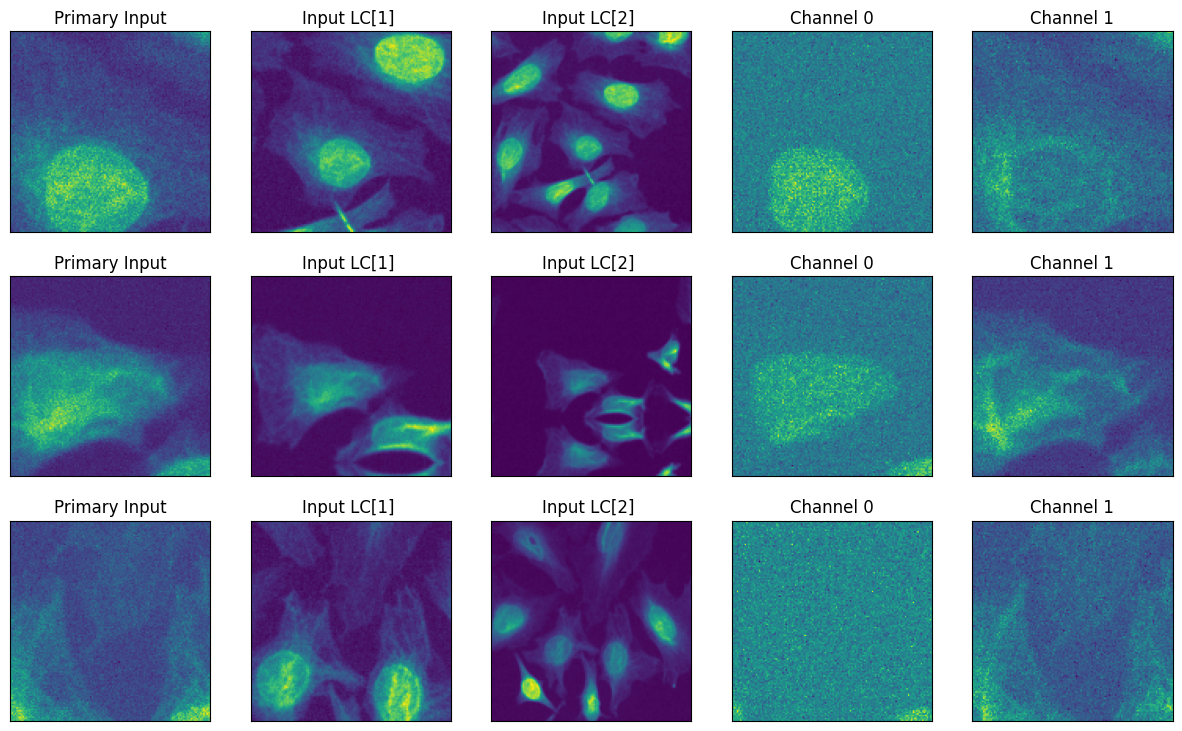

In [22]:
plot_input_patches(dataset=train_dset, num_channels=2, num_samples=3, patch_size=128)

### Train the model
<div class="alert alert-block alert-info">
<b> Task: </b>If the training is taking too long, set max_epochs to a lower value.
Alternatively, you can also reduce the dataset size by setting reduce_data=True.
</div>


In [23]:
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks(f"./checkpoints/{EXPOSURE_DURATION}/"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/t


  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | model                  | LadderVAE              | 3.6 M  | train
1 | noise_model            | MultiChannelNoiseModel | 0      | train
2 | noise_model_likelihood | NoiseModelLikelihood   | 0      | train
3 | gaussian_likelihood    | GaussianLikelihood     | 0      | train
--------------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.270    Total estimated model params size (MB)
321       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
Metric val_loss improved. New best score: 2.615


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 1e-06. New best score: 2.573


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 1e-06. New best score: 2.568


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-06. New best score: 2.560


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-06. New best score: 2.560


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 1e-06. New best score: 2.538
`Trainer.fit` stopped: `max_epochs=10` reached.


## Metrics during training
We show training reconstruction loss and training kl divergence loss, validation reconstruction loss and validation PSNR for every epoch. 

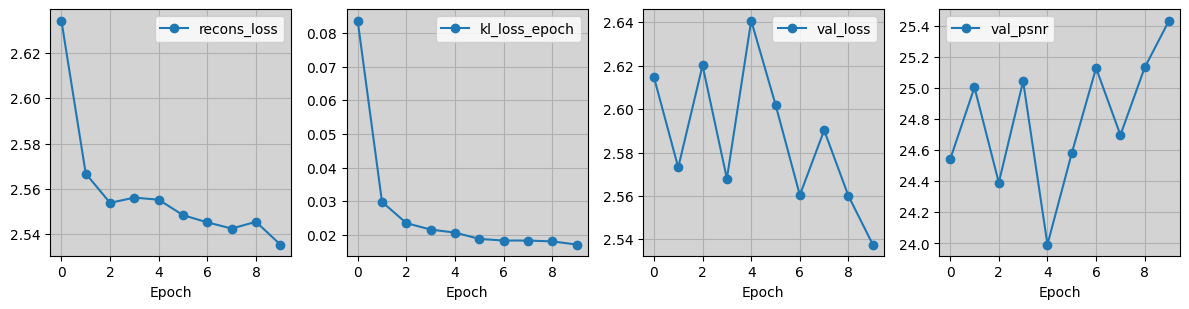

In [24]:
from pandas import read_csv
from notebook_utils import find_recent_metrics, plot_metrics
df = read_csv(find_recent_metrics())
plot_metrics(df)

In [25]:
from notebook_utils import get_unnormalized_predictions, get_target, get_input
stitched_predictions, _, _ = get_unnormalized_predictions(model, val_dset, EXPOSURE_DURATION, TARGET_CHANNEL_IDX_LIST, 
                                                    mmse_count = experiment_params['mmse_count'], num_workers=4, batch_size=8)
tar = get_target(val_dset)
inp = get_input(val_dset)

Predicting tiles:   0%|          | 0/313 [00:00<?, ?it/s]

Predicting tiles: 100%|██████████| 313/313 [01:47<00:00,  2.92it/s]


## Inspecting Input, Target and Predictions for one entire frame

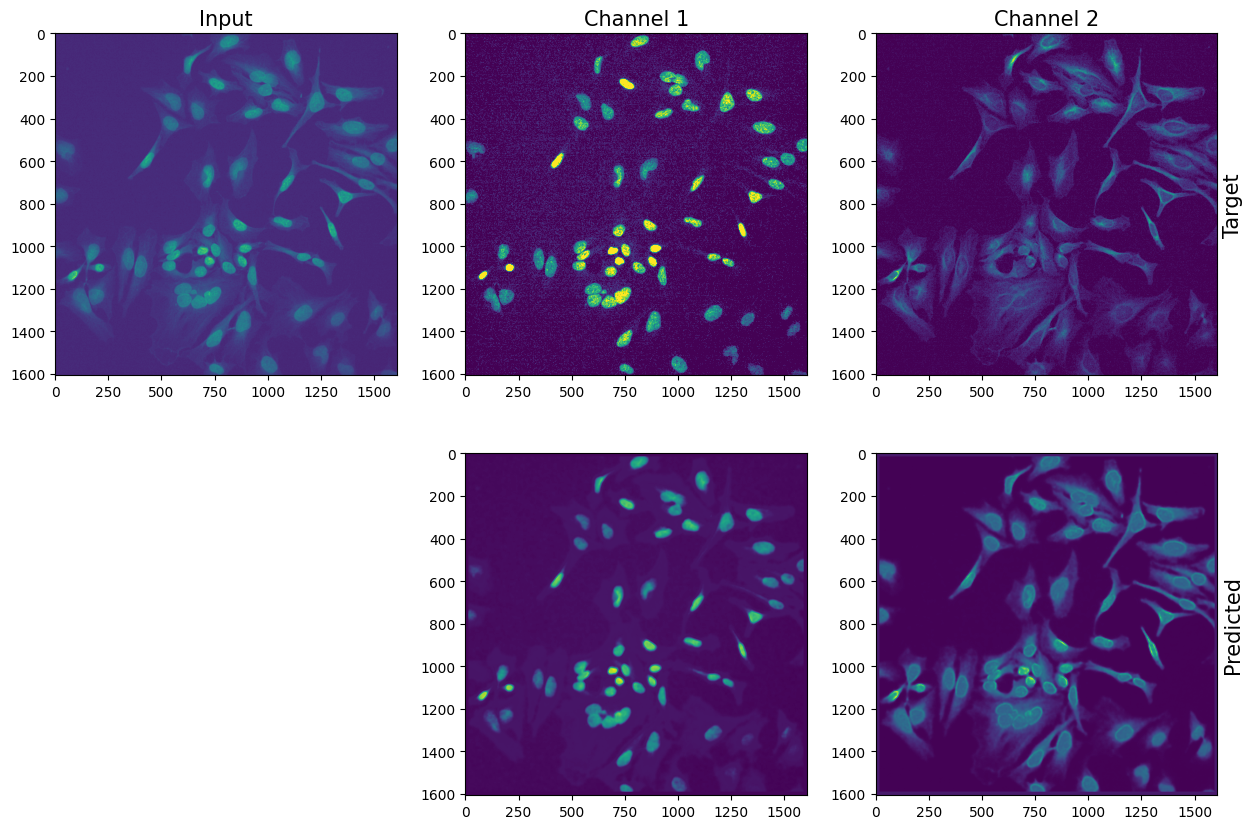

In [26]:
from notebook_utils import full_frame_evaluation
frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Visualizing the prediction results on few random foreground locations
Here, we show few random foreground locations and the corresponding predictions from the dataset.

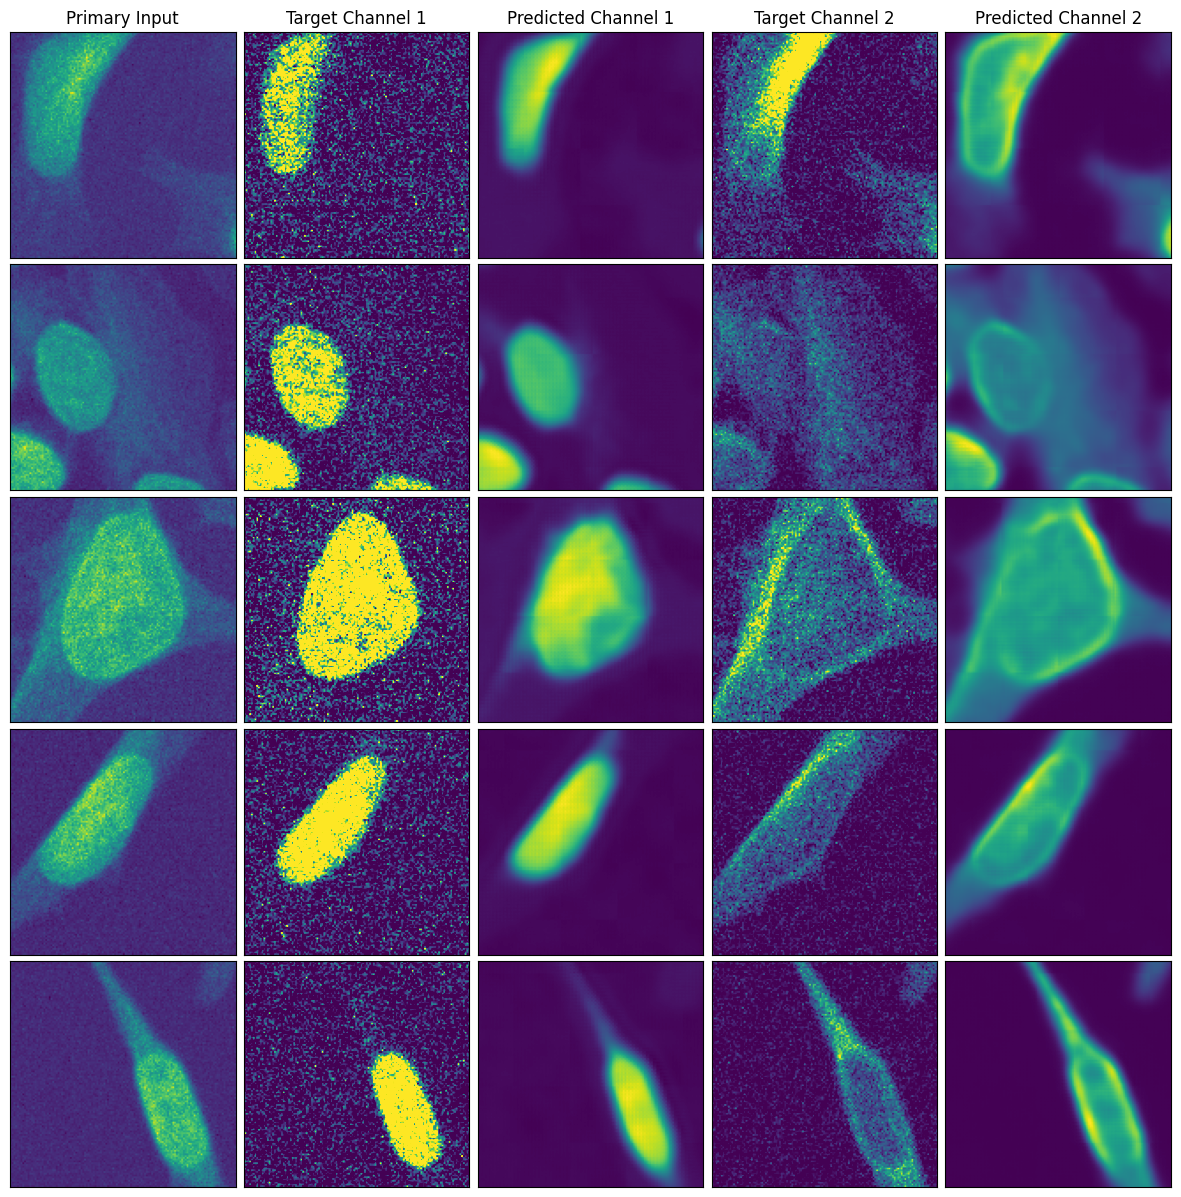

In [27]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from notebook_utils import pick_random_patches_with_content
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[2,0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[2,1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 2*len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
    for j in range(ncols//2):
        vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].min()
        vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].max()
        ax[i,2*j+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)
        ax[i,2*j+2].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)

ax[0,0].set_title('Primary Input')
for i in range(len(TARGET_CHANNEL_IDX_LIST)):
    ax[0,2*i+1].set_title(f'Target Channel {i+1}')
    ax[0,2*i+2].set_title(f'Predicted Channel {i+1}')

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

### Manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task: </b> Set h_start, w_start to inspect the predictions at a specific location.
</div>


Text(0, 0.5, 'Predicted')

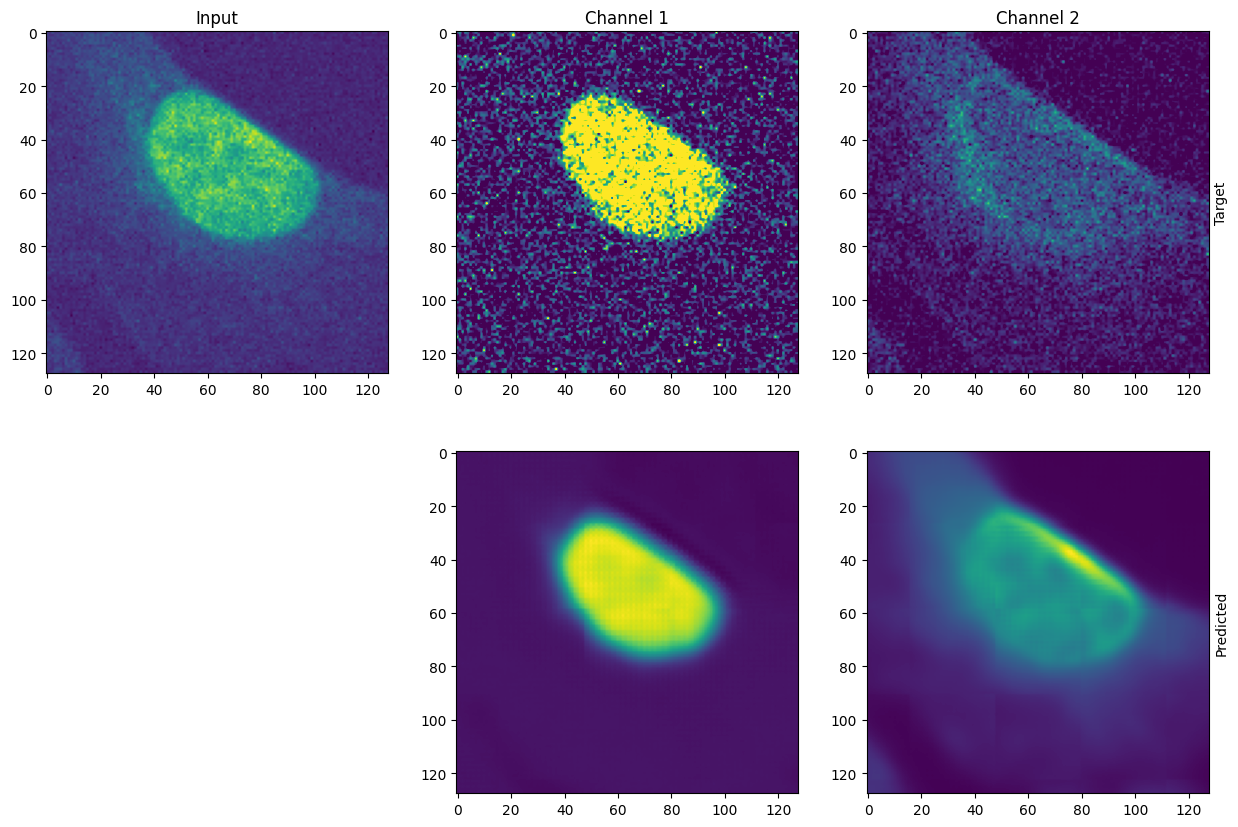

In [28]:
import numpy as np
h_start = 853 #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = 800 #np.random.randint(stitched_predictions.shape[2] - img_sz)




img_sz = 128
ncols = len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
for i in range(ncols -1):
    vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i].min()
    vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i].max()
    ax[0,i+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i], vmin=vmin, vmax=vmax)
    ax[1,i+1].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,i], vmin=vmin, vmax=vmax)

# disable the axis for ax[1,0]
ax[1,0].axis('off')
ax[0,0].set_title("Input")
ax[0,1].set_title("Channel 1")
ax[0,2].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0,2].yaxis.set_label_position("right")
ax[0,2].set_ylabel("Target")

ax[1,2].yaxis.set_label_position("right")
ax[1,2].set_ylabel("Predicted")

## Sampling
For a given input patch, our MicroSplit network can generate multiple outputs. This allows the user to visually judge uncertainty in predictions. 
We show the sampling results for a few random foreground locations. Re-run the cell to see different samples.

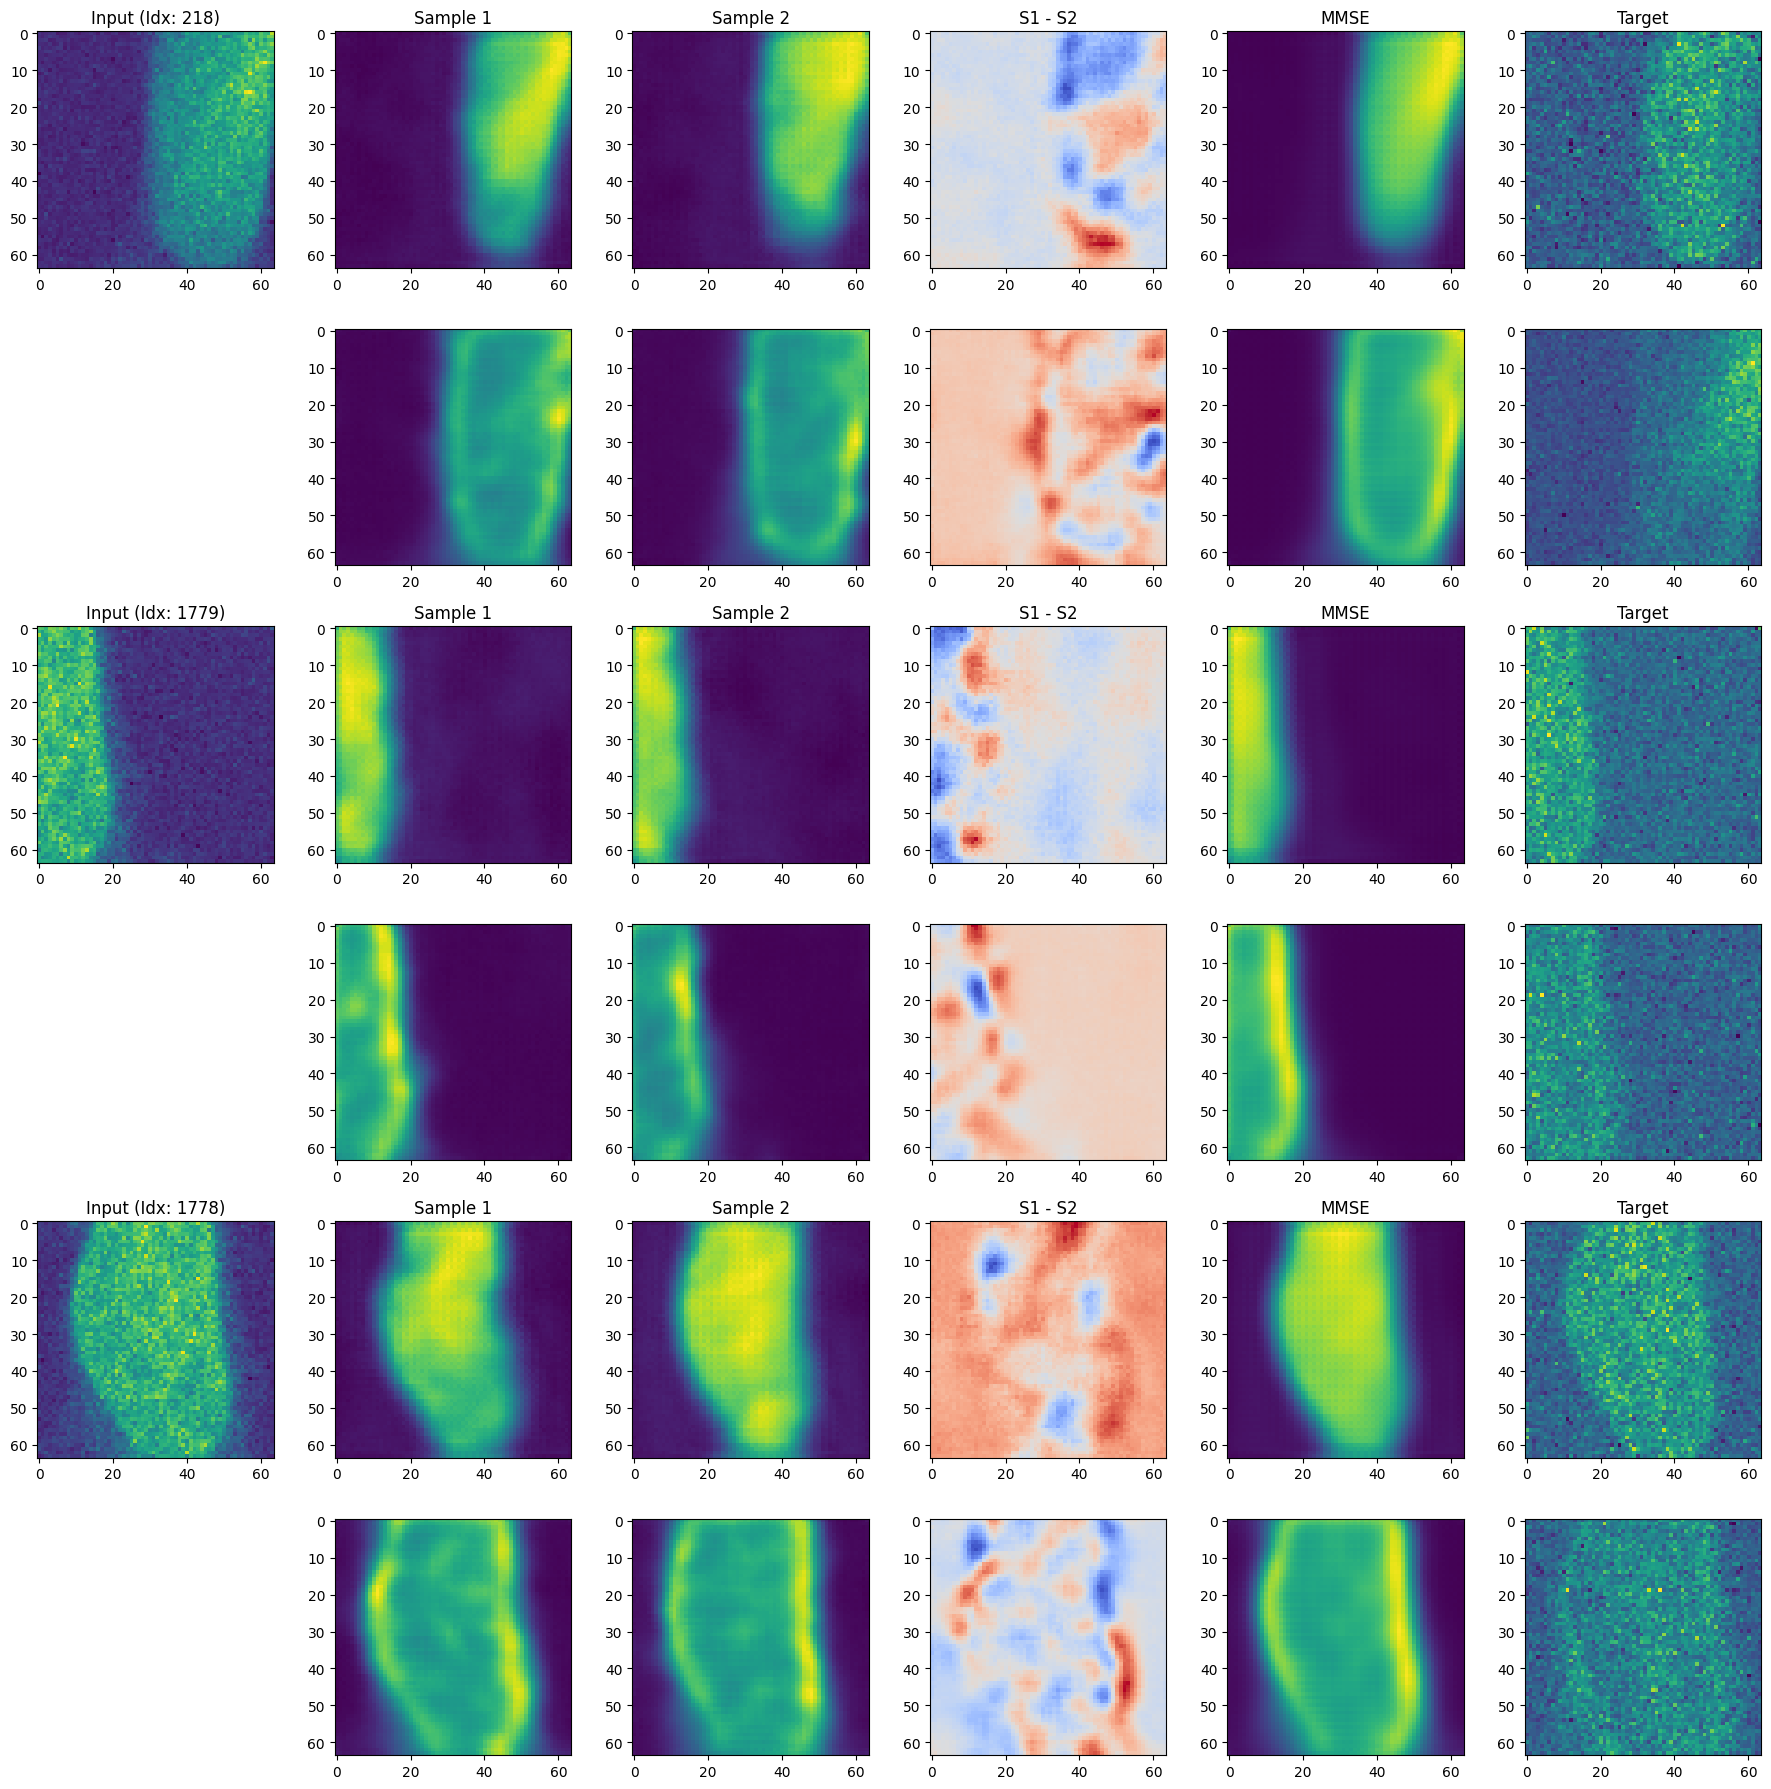

In [29]:
from notebook_utils import show_sampling
imgsz = 3
ncols = 6
examplecount = 3
_,ax = plt.subplots(figsize=(imgsz*ncols, imgsz*2*examplecount), ncols=ncols, nrows=2*examplecount)

show_sampling(val_dset, model, ax=ax[:2])
show_sampling(val_dset, model, ax=ax[2:4])
show_sampling(val_dset, model, ax=ax[4:6])
plt.tight_layout()

<div class="alert alert-block alert-success">
    <!-- <h2> Summary </h2> -->
<b>Success</b>: In this notebook, you trained the MicroSplit model on HT-LIF24 dataset. You can now evaluate the model on the test dataset using 02_evaluation.ipynb.
</div>
